In [110]:
import numpy as np
import pandas as pd # read_csv, get_dumies(원핫인코딩)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # 훈련셋과 시험셋 나누기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.activations import relu, softmax # activation = 'relu' 대신 사용
import matplotlib.pyplot as plt

- Red Wine 품질 등급 예측
    1. 데이터 셋 확보 & 전처리
        독립변수, 종속변수 분리 -> 독립변수 스케일조정(StandardScaler), 종속변수 원핫인코딩(get_dummies), 
         훈련셋과 테스트셋 분리(train_test_split)
    2. 모델 구성(입력11, 출력6) layer층 4
    3. 모델 학습 과정 설정(다중분류에 맞는 설정)
    4. 학습시키기 (callbacks이용)
    5. 모델 평가 - 그래프, 평가(테스트셋), 교차표(crosstab)
    6. 모델 저장 및 모델사용하기

## 1. 데이터 셋 확보 & 전처리 독립변수, 종속변수 분리 -> 독립변수 스케일조정(StandardScaler), 종속변수 원핫인코딩(get_dummies), 훈련셋과 테스트셋 분리(train_test_split)

In [2]:
redwine = pd.read_csv('./data/winequality-red.csv', sep=';')
redwine.quality.unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

In [3]:
redwine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
X = redwine.iloc[:,:-1]
y = redwine.iloc[:,-1:]
X.shape, y.shape

((1599, 11), (1599, 1))

In [65]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-0.52835961,  0.96187667, -1.39147228, ...,  1.28864292,
        -0.57920652, -0.96024611],
       [-0.29854743,  1.96744245, -1.39147228, ..., -0.7199333 ,
         0.1289504 , -0.58477711],
       [-0.29854743,  1.29706527, -1.18607043, ..., -0.33117661,
        -0.04808883, -0.58477711],
       ...,
       [-1.1603431 , -0.09955388, -0.72391627, ...,  0.70550789,
         0.54204194,  0.54162988],
       [-1.39015528,  0.65462046, -0.77526673, ...,  1.6773996 ,
         0.30598963, -0.20930812],
       [-1.33270223, -1.21684919,  1.02199944, ...,  0.51112954,
         0.01092425,  0.54162988]])

In [6]:
y = pd.get_dummies(y['quality']).values
y.shape

(1599, 6)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1119, 11), (480, 11), (1119, 6), (480, 6))

## 2. 모델 구성(입력11, 출력6) layer층 4

In [117]:
model = Sequential()

model.add(Input(shape=(11,)))
model.add(Dense(units=64, activation=relu))
model.add(Dense(units=128, activation=relu))
model.add(Dropout(0.3))
model.add(Dense(units=32, activation=relu))
model.add(Dense(units=6, activation=softmax))

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 64)                768       
                                                                 
 dense_61 (Dense)            (None, 128)               8320      
                                                                 
 dropout_32 (Dropout)        (None, 128)               0         
                                                                 
 dense_62 (Dense)            (None, 32)                4128      
                                                                 
 dense_63 (Dense)            (None, 6)                 198       
                                                                 
Total params: 13,414
Trainable params: 13,414
Non-trainable params: 0
_________________________________________________________________


## 3. 모델 학습 과정 설정(다중분류에 맞는 설정)

In [118]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

## 4. 학습시키기 (callbacks이용)

In [119]:
class CustomHistory(Callback):
    def __init__(self):
        self.epoch = 0
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if self.epoch%50 == 0:
            print('epoch:{}, loss:{}, acc:{}, val_loss{}, val_acc:{}'.format(self.epoch, 
                                                                             logs.get('loss'),
                                                                             logs.get('accuracy'),
                                                                             logs.get('val_loss'),
                                                                             logs.get('val_accuracy')))

In [120]:
custom_history = CustomHistory()
early_stopping = EarlyStopping(patience=50)
hist = model.fit(X_train, y_train,
          epochs=1000,
          validation_split = .2,
          verbose=0,
          callbacks=[early_stopping, custom_history])

epoch:50, loss:0.5535684823989868, acc:0.7720670104026794, val_loss1.1695592403411865, val_acc:0.5625


## 5. 모델 평가 - 그래프, 평가(테스트셋), 교차표(crosstab)

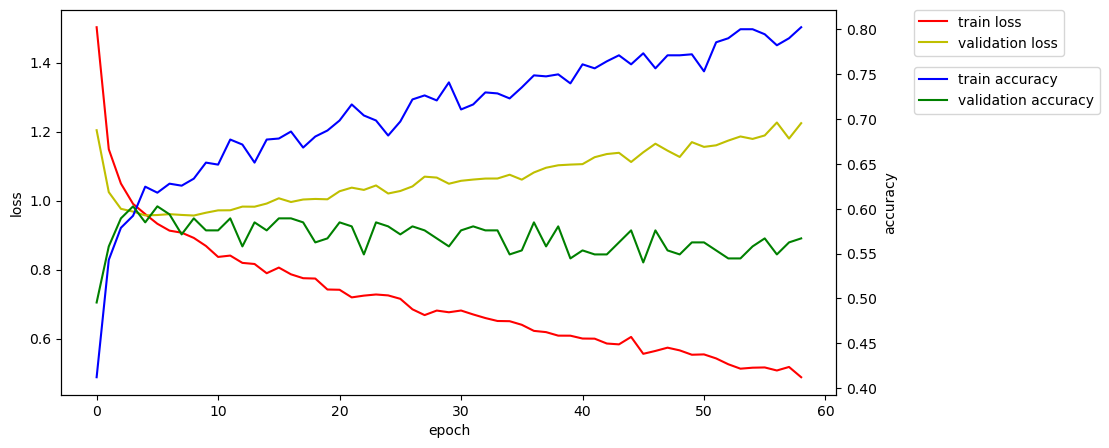

In [121]:
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0.)
acc_ax.legend(bbox_to_anchor=(1.1, .85), loc=2, borderaxespad=0.)
plt.show()

In [122]:
score = model.evaluate(X_test, y_test)
print('loss :',score[0])
print('accuracy :',score[1])

15/15 [==============================] - 0s 3ms/step - loss: 1.1944 - accuracy: 0.6104
loss : 1.1944226026535034
accuracy : 0.6104166507720947


In [125]:
Y_hat = model.predict(X_test).argmax(axis=1)+3
Y_hat

15/15 [==============================] - 0s 2ms/step


array([4, 5, 7, 7, 7, 5, 6, 7, 5, 5, 6, 6, 6, 5, 6, 5, 7, 5, 5, 5, 5, 6,
       6, 6, 7, 6, 6, 5, 6, 6, 5, 6, 5, 5, 5, 7, 6, 6, 5, 5, 5, 7, 5, 6,
       6, 5, 5, 5, 6, 6, 5, 5, 6, 6, 5, 6, 5, 6, 7, 5, 6, 7, 6, 7, 7, 6,
       6, 6, 5, 5, 7, 5, 5, 5, 5, 6, 7, 6, 5, 6, 5, 6, 5, 5, 6, 6, 5, 6,
       6, 7, 5, 6, 6, 5, 6, 5, 6, 6, 5, 5, 7, 5, 6, 6, 6, 5, 5, 5, 6, 5,
       5, 5, 6, 5, 6, 5, 5, 6, 6, 5, 5, 6, 6, 5, 7, 5, 6, 6, 6, 8, 5, 5,
       6, 6, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 6, 5, 6, 5, 5, 5, 6,
       6, 7, 6, 5, 6, 4, 5, 6, 6, 5, 6, 5, 5, 5, 7, 6, 7, 5, 6, 5, 6, 6,
       5, 5, 5, 6, 5, 5, 6, 5, 5, 6, 6, 6, 5, 5, 7, 6, 6, 5, 6, 5, 6, 6,
       6, 5, 5, 6, 7, 6, 6, 6, 5, 6, 6, 6, 6, 5, 6, 6, 6, 6, 7, 6, 6, 6,
       6, 6, 6, 7, 6, 5, 5, 5, 5, 7, 6, 6, 5, 6, 5, 6, 5, 7, 6, 5, 6, 6,
       6, 6, 7, 6, 5, 5, 6, 5, 5, 5, 5, 5, 6, 8, 5, 5, 7, 5, 6, 6, 6, 5,
       5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 6, 6, 4, 6, 6, 6, 8, 5, 7, 5, 5, 5,
       6, 6, 6, 5, 6, 7, 7, 6, 6, 6, 5, 6, 7, 7, 5,

In [128]:
ctab = pd.crosstab(y_test.argmax(axis=1)+3, Y_hat)
ctab.index.name = '실제'
ctab.columns.name = '예측'
ctab

예측,4,5,6,7,8
실제,,,,,
3,0,3,0,0,0
4,0,14,2,0,0
5,2,140,57,5,0
6,3,50,119,17,3
7,0,3,22,34,1
8,0,0,2,3,0


## 6.모델 저장 및 모델사용하기

In [74]:
model.save('model/redwine.h5')

In [75]:
from tensorflow.keras.models import load_model
model2 = load_model('model/redwine.h5')
model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 64)                768       
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 128)               8320      
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 32)                4128      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_31 (Dense)            (None, 6)                

In [76]:
model2.predict(X_test).argmax(axis=1)

15/15 [==============================] - 0s 3ms/step


array([3, 3, 3, 2, 2, 4, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 1, 4, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 4, 2, 3, 2, 4, 2, 2, 2,
       4, 2, 3, 3, 3, 2, 3, 3, 4, 4, 2, 2, 2, 2, 3, 4, 3, 2, 2, 4, 4, 3,
       1, 4, 2, 2, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 2, 2, 3, 3, 2, 3,
       3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 4, 2, 2, 3, 2, 0, 3, 2, 3, 3,
       2, 4, 3, 3, 3, 3, 3, 4, 2, 3, 2, 3, 2, 4, 1, 4, 2, 4, 2, 2, 3, 2,
       4, 2, 3, 2, 3, 2, 4, 2, 3, 4, 2, 3, 4, 2, 3, 2, 2, 4, 2, 3, 2, 2,
       2, 2, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3, 4, 2, 3, 2, 2, 3, 2, 2, 3, 3,
       2, 2, 2, 2, 4, 4, 2, 2, 3, 4, 2, 4, 3, 2, 4, 3, 3, 2, 2, 3, 2, 2,
       3, 4, 3, 4, 4, 3, 3, 3, 4, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 4, 3, 2,
       2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 3, 3, 2, 2, 4, 2,
       2, 4, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 3, 4, 3, 2, 4, 3, 3, 2, 4,
       3, 2, 4, 4, 3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 3, 4, 2, 3, 2, 4, 3, 2,
       2, 2, 3, 3, 2, 2, 3, 3, 2, 3, 2, 3, 4, 2, 4,